In [1]:
import numpy as np
import matplotlib.pyplot as plt
import utilities
utilities.init(use_latex = False)

K_B = 8.617e-5 # Boltzmann's constant (eV/K)

def energy(state, interaction_energy):
    """ 
    Calculates the total energy assigned to the 2D spin lattice described 
    by `state`. We assume periodic boundary conditions
    """    
    
    state_shift_right = np.roll(state, 1, axis = 1)
    state_shift_down = np.roll(state, 1, axis = 0)
    
    # count horizontal and vertical interactions
    h_bonds = np.sum(state*state_shift_right)
    v_bonds = np.sum(state*state_shift_down)
    
    return -interaction_energy*(h_bonds + v_bonds)


def metropolis(rng, num_steps, interaction_energy, lattice_size, temp):
    """
    Simulates a single markov chain according to the metropolis algorithm, 
    specifically for a Boltzmann stationary distribution. Proposal perturbations
    are obtained by randomly flipping a single spin. 
    """
    
    state_hist = np.zeros((num_steps, lattice_size, lattice_size))
    energy_hist = np.zeros(num_steps)
    
    # random +/-1 initial spins
    state_hist[0] = rng.choice([-1, 1], (lattice_size, lattice_size))
    
    # Initial energy
    energy_hist[0] = energy(state_hist[0], interaction_energy)
    
    # Simulate MC for 'num_steps' steps
    for n in range(0, num_steps-1):
        # flip a single spin uniformly at random, then calculate energy
        perturbed_state = np.copy(state_hist[n])
        i = rng.choice(lattice_size)
        j = rng.choice(lattice_size)
        perturbed_state[i,j] *= -1
        perturbed_energy = energy(perturbed_state, interaction_energy)
        
        # Metropolis criterion for Boltzmann distribution
        u = rng.random()
        if u < np.exp((energy_hist[n] - perturbed_energy)/(K_B*temp)): # Accept
            state_hist[n+1] = perturbed_state
            energy_hist[n+1] = perturbed_energy
            
        else: # Reject - use previous state
            state_hist[n+1] = state_hist[n]
            energy_hist[n+1] = energy_hist[n]
            
    return state_hist, energy_hist
            
    

In [2]:
A = np.zeros((5,3))
for i in range(5):
    for j in range(3):
        A[i,j] = (i+1)*10 + j+1
        
print("A:\n", A)
print("\nnp.roll(A, 1, axis = 0):\n", np.roll(A, 1, axis = 0))
print("\nnp.roll(A, 1, axis = 1):\n", np.roll(A, 1, axis = 1))

A:
 [[11. 12. 13.]
 [21. 22. 23.]
 [31. 32. 33.]
 [41. 42. 43.]
 [51. 52. 53.]]

np.roll(A, 1, axis = 0):
 [[51. 52. 53.]
 [11. 12. 13.]
 [21. 22. 23.]
 [31. 32. 33.]
 [41. 42. 43.]]

np.roll(A, 1, axis = 1):
 [[13. 11. 12.]
 [23. 21. 22.]
 [33. 31. 32.]
 [43. 41. 42.]
 [53. 51. 52.]]


In [3]:
RNG = np.random.default_rng(seed=12345)
RNG.choice([-1, 1], (5,5))

array([[ 1, -1,  1, -1, -1],
       [ 1,  1,  1,  1, -1],
       [ 1, -1,  1,  1, -1],
       [-1, -1,  1,  1,  1],
       [ 1, -1,  1,  1,  1]])

## Running Metropolis

Text(0, 0.5, 'Total Energy (eV)')

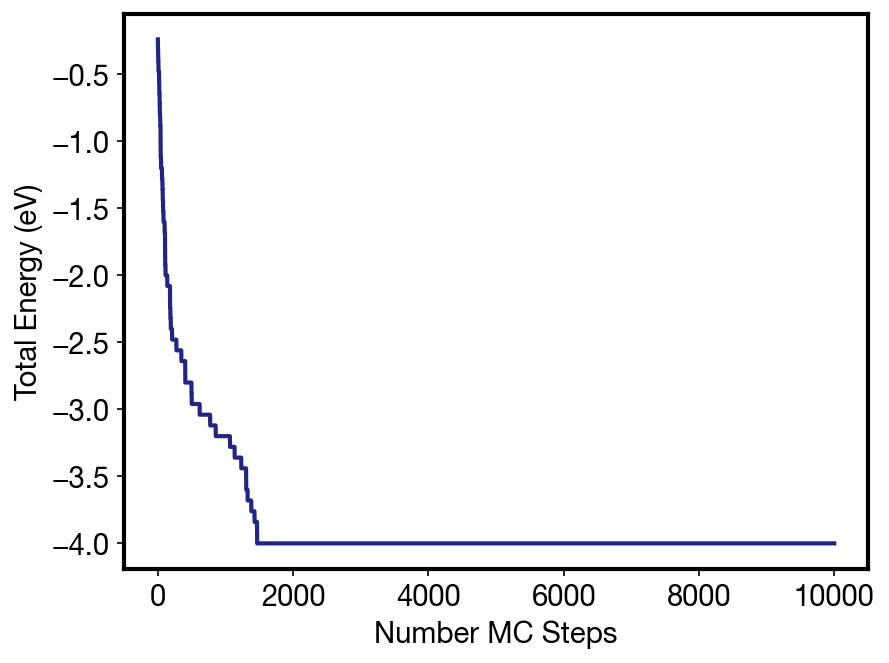

In [10]:
RNG = np.random.default_rng(seed=12345)
NUM_STEPS = 10000
INTERACTION_ENERGY = 0.02 # eV
LATTICE_SIZE = 10
TEMP = 100 # K

# Run Metropolis to obtain a single chain
state_hist, energy_hist = metropolis(RNG, NUM_STEPS, INTERACTION_ENERGY, 
                                     LATTICE_SIZE, TEMP)

plt.plot(energy_hist)
plt.xlabel('Number MC Steps')
plt.ylabel('Total Energy (eV)')

What is the effect of temperature or number of steps?

# Ergodic sampling

In [6]:
RNG = np.random.default_rng(seed=12345)
NUM_STEPS = 10000
INTERACTION_ENERGY = 0.02 # eV
LATTICE_SIZE = 10
TEMP = 500 
BURN_IN = 6000
THIN_RATE = 10

# Run Metrpolis to obtain a single chain
state_hist, energy_hist = metropolis(RNG,  NUM_STEPS,  INTERACTION_ENERGY, 
                                     LATTICE_SIZE, TEMP)

# Subsample later states for a population from which we can calculate statistics

sampled_states = state_hist[BURN_IN:-1:THIN_RATE]
sampled_energies = energy_hist[BURN_IN:-1:THIN_RATE]
print("%d sampled states" % len(sampled_states))

400 sampled states


Expected net magnetization @ temp  500 K: 88


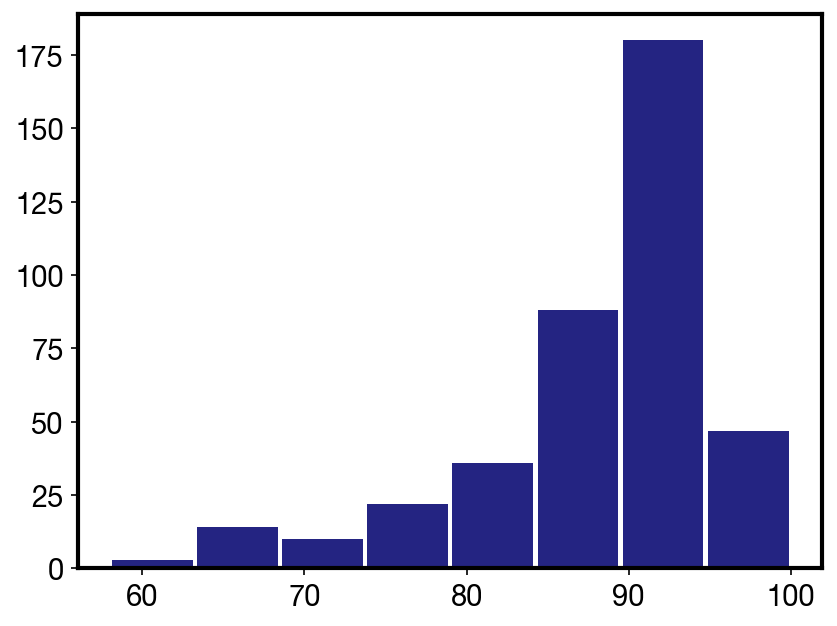

In [7]:
# Calculate the net magnitatization for all sampled states
net_magnetization = np.abs(np.sum(np.sum(sampled_states, axis = 2), axis = 1))
plt.hist(net_magnetization, bins = len(sampled_states)//50, rwidth=0.95)

# MC calculated exected (averaged) net magnitization
print("Expected net magnetization @ temp %4.0f K: %d" % 
      (TEMP, np.mean(net_magnetization)))

# Net magnetization versus temperature

In [8]:
def exp_net_magnetization(rng, temp, num_steps, interaction_energy, 
                          lattice_size, burn_in, thin_rate):
    # Run Metropolis to obtain a single chain
    state_hist, energy_hist = metropolis(rng, num_steps, interaction_energy, 
                                         lattice_size, temp)
    
    # apply burn-in and thinning:
    sampled_states = state_hist[burn_in:-1:thin_rate]
    sampled_energies = energy_hist[burn_in:-1:thin_rate] 
    
    # Calculate the net magnitatization for all sampled states
    net_magnetization = np.abs(
        np.sum(np.sum(sampled_states, axis = 2), axis = 1))
    
    # Return expected magnetization
    return np.mean(net_magnetization)    

Text(0, 0.5, 'Net Magnetization')

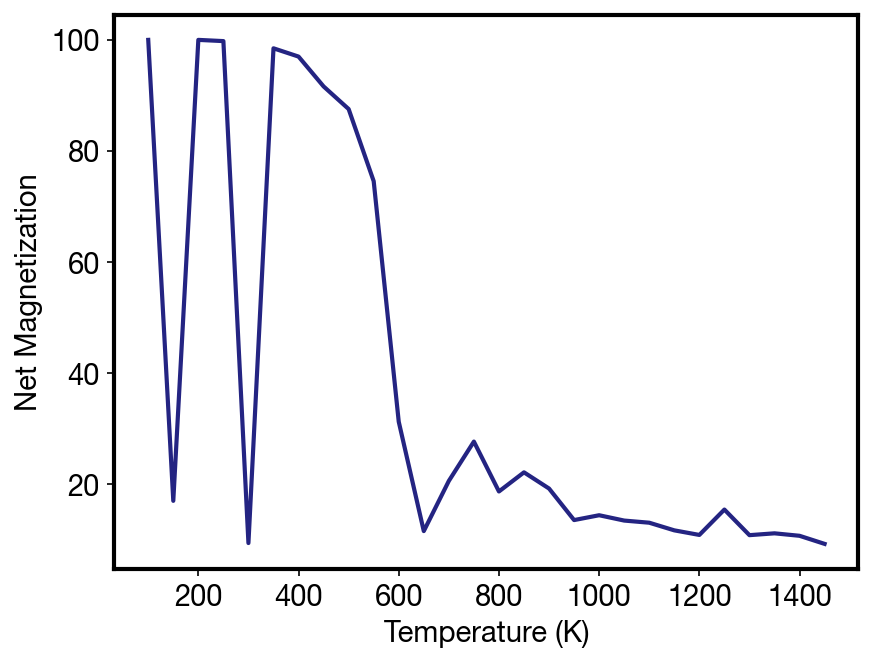

In [9]:
RNG = np.random.default_rng(seed = 12345)
INTERACTION_ENERGY = 0.02 # eV
LATTICE_SIZE = 10
NUM_STEPS = 10000
BURN_IN = 6000
THIN_RATE = 10

temps = range(100, 1500, 50)
net_magnetizations = np.zeros(len(temps))
    
for i, temp in enumerate(temps):
    net_magnetizations[i] = exp_net_magnetization(RNG, temp, NUM_STEPS, 
                                                  INTERACTION_ENERGY, 
                                                  LATTICE_SIZE, 
                                                  BURN_IN, THIN_RATE)
plt.plot(temps, net_magnetizations)
plt.xlabel('Temperature (K)')
plt.ylabel('Net Magnetization')

* Low temperature, number of steps, ergodic assumptions and effect of initial state.

Text(0, 0.5, 'Net Magnetization')

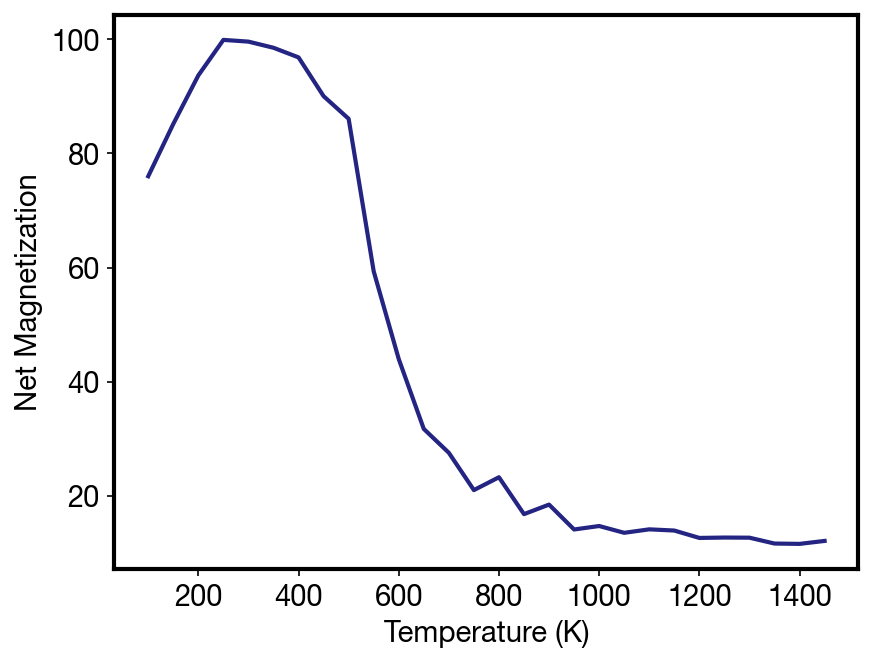

In [11]:
RNG = np.random.default_rng(seed = 12345)
INTERACTION_ENERGY = 0.02 # eV
LATTICE_SIZE = 10
NUM_STEPS = 10000
BURN_IN = 6000
THIN_RATE = 10
NUM_CHAINS = 10

temps = range(100, 1500, 50)
net_magnetizations = np.zeros((len(temps), NUM_CHAINS))

# Now iterate over temperatures and several chains per temperature
for i, temp in enumerate(temps):
    for j in range(NUM_CHAINS):
        net_magnetizations[i, j] = exp_net_magnetization(RNG, temp, NUM_STEPS, 
                                                         INTERACTION_ENERGY, 
                                                         LATTICE_SIZE, 
                                                         BURN_IN, THIN_RATE)
        
# Average over chains, then plot
net_magnetizations = np.mean(net_magnetizations, axis=1)
plt.plot(temps, net_magnetizations)
plt.xlabel('Temperature (K)')
plt.ylabel('Net Magnetization')